<a href="https://colab.research.google.com/github/UNIST-LIM-Lab-course/k-fold-cross-validation-assigment-JJukE/blob/main/k_fold_cross_validation_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cousre : IE408_AI502_IE511
### 2022.09.16



# Model selection via K-fold cross validation

## Table of Contents
---
- Custom dataset <br>
- $K$-fold cross validation (Assigment)<br>
- Custom activation function (Assigment)<br>
- MLP construction<br>
- Hyperparameter tuning<br>

<br>

**`Assigment`** : Complete the two cell marked with (Assignment)
- (Assignment) $K$-fold cross validation
- (Assignment) Activation function with implementing forward and backward step
- 🚨 Please **do not modify** code that is not an Assigment cell
- 🚨 Please **do not add** any cells




# import library

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.autograd import Function  # to create custom activation function

import pandas as pd
import numpy as np

# Boston house prices dataset specification

<img src = https://user-images.githubusercontent.com/43310063/188207759-db4dad3f-31e2-4fd2-9f71-7eaaf3f88329.png>

### Data examples
<img src = https://user-images.githubusercontent.com/43310063/188208483-f6dc9c50-3399-4607-af6b-cc3a444895e8.png>

# Custom dataset in PyTorch
### If you make *custom dataset*, you can use dataloader in pytorch
<br>

PyTorch `DATASETS` & `DATALOADERS` : <br>

- `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. <br>
- `Dataset` stores the samples and their corresponding labels.
- `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.
<br><br>

- Creating a Custom Dataset for your files<br>
    - A custom Dataset class must implement three functions: `__init__`, `__len__,` and `__getitem__`.
    - The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).
    - The `__len__` function returns the number of samples in our dataset.
    - The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`


In [11]:

class BostonDataset(Dataset):  # from torch.utils.data import Dataset
    def __init__(self, features, targets, train_mean=None, train_std=None):
        self.features = torch.Tensor(features)
        self.targets = torch.Tensor(targets).reshape(-1, 1)

        # Standard Scaler using train_data's mean and train_data's std
        if (train_mean is not None) and (train_std is not None):
            self.features = (self.features - train_mean) / train_std

    def __len__(self):  # return length of dataset
        return len(self.targets)

    def __getitem__(self, idx):  # return data with index(idx)
        X = self.features[idx, :] 
        y = self.targets[idx]
        
        return X, y

# $K$-fold cross validation

- Lecture note has details (Week2-MLP)<br>

- $K$-fold cross validation procedure
    1. Divide the training dataset into k-parts
    2. Use k-1 parts as training set and 1 part as validation set
    3. Repeat the procedure K times, rotating the validation set
    4. Average validation errors


# (Assignment) $K$-fold cross validation

- Write your code in loops 
- Do not use any external library

<br>

return `rets` that is list <br> <br>
`rets` form : \\
　　　　[[train_index_list_1, validation_index_list_1], \\
　　　　[train_index_list_2, validation_index_list_2], \\
　　　　... \\
　　　　[train_index_list_k, validation_index_list_k]] \\
<br>
len(`rets`) : k \\
`rets`[0] : [train_index_list, validation_index_list]

In [12]:
def k_fold_data(dataset, k):
    rets = [] # list will have k-fold data, example rets[[train_index_list_1, validation_index_list_1], ... [train_index_list_k, validation_index_list_k]]
    fold_size = len(dataset) // k
    for i in range(k):
        #### TODO : WRITE YOUR CODE IN THIS LOOP & COMPLETE k-fold ####
        validation_idx = list(range(fold_size * i, fold_size * (i + 1)))
        train_idx = list(range(0, fold_size * i)) + list(range(fold_size * (i + 1), len(dataset)))
        
        rets.append([train_idx, validation_idx])

        # form of return variable :
        # len(rets) : k 
        # rets[0] : [train_index_list, validation_index_list]
        # example : 
        #   rets : [[[fold_size, ... len of dataset], [0, 1, .. fold_size-1],
        #           [train_index_list_2, validation_index_list_2],
        #           ...
        #           [train_index_list_k, validation_index_list_k]]
        #######################################################
    return rets

# Load dataset & Split dataset

In [13]:
# Load Boston house prices dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

X_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_data = raw_df.values[1::2, 2]

X_data = X_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# Split the dataset into a training dataset and a test dataset
test_size = 0.2
train_len = int(X_data.shape[0] * (1-test_size))

X_train, X_test = X_data[: train_len, :], X_data[train_len:, :]
y_train, y_test = y_data[: train_len], y_data[train_len:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


# Custom activation function

## Activation function without trainable parameter
- sigmoid activation function
### $\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1+\text{exp}(-x)}$

In [14]:
def sigmoid_(x):
    return 1 / (1 + torch.exp(-x))

class sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return sigmoid_(x)

## Activation function with implementing forward and backward step
- tanh activation function
### $\text{tanh} = \frac{\text{exp}(x) - \text{exp}(-x)}{\text{exp}(x) + \text{exp}(-x)}$



In [15]:
def tanh_(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

class tanh(Function):  # from torch.autograd import Function
    
    @staticmethod  # python decorator
    def forward(ctx, x):
        ctx.save_for_backward(x)
        
        output = tanh_(x)
        
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # At the top of backward unpack saved_tensors and initialize all gradients w.r.t. inputs to None.

        x, = ctx.saved_tensors

        if ctx.needs_input_grad[0]:
            grad_input = 1 - tanh_(x) ** 2 # derivative of tanh(x) : 1 - tanh^2(x)

        return grad_input * grad_output



# (Assignment) Activation function with implementing forward and backward step

- Write activation function, forward and backward step
- Swish (paper : https://arxiv.org/abs/1710.05941)
### $\text{swish}(x) = x * \text{Sigmoid}(\beta x)$
- $\beta$ is a constant or trainable parameter
- In this practice, $\beta$ is fixed to 1

In [16]:
class swish(Function):
    
    @staticmethod  # python decorator
    def forward(ctx, x):
        #### TODO : WRITE YOUR CODE ####
        ctx.save_for_backward(x)

        output = x * (1 / (1 + torch.exp(-x)))
        
        return output
        ################################

    @staticmethod
    def backward(ctx, grad_output):
        # At the top of backward unpack saved_tensors and initialize all gradients w.r.t. inputs to None.
        #### TODO : WRITE YOUR CODE ####
        x, = ctx.saved_tensors
        grad_input = None

        if ctx.needs_input_grad[0]:
          # derivative of swish(x) when beta=1 : sigmoid(x) + swish(x)(1 - sigmoid(x))
          grad_input = 1 / (1 + torch.exp(-x)) + (x * 1 / (1 + torch.exp(-x))) * (1 - 1 / (1 + torch.exp(-x)))
        
        return  grad_input * grad_output # initialize all gradients w.r.t. inputs to None.
        ################################

# Neural Network model class

In [17]:
class MLP(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, dropout_rate=0.2):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(n_feature, n_hidden)
        self.a1 = swish.apply  # activation function we implemented
        
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.a2 = swish.apply

        self.fc3 = nn.Linear(n_hidden, n_output)

        self.dropout = nn.Dropout(dropout_rate) # dropout with dropout_rate
        
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.dropout(x)

        x = self.a2(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x


# Training 
- Training with $K$-fold
- Hyperparameter optimization (HPO)

In [18]:
from itertools import product

# training hyperparameters used to HPO
hpo_vals = {  # our search space for HPO
    'learning_rate': [0.001, 0.005, 0.01],
    'weight_decay' : [0.7, 0.8, 0.9],
    'dropout_rate' : [0.1, 0.2, 0.3],
}
hp_candidates = []

items = sorted(hpo_vals.items())
keys, vals = zip(*items)

# product do cartesian product, so it creates all combinations
for v in product(*vals):  
    hp_candidates.append(dict(zip(keys, v)))

print("Length of hyperparameter candidates :", len(hp_candidates))
print(hp_candidates)

Length of hyperparameter candidates : 27
[{'dropout_rate': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.7}, {'dropout_rate': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.8}, {'dropout_rate': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.9}, {'dropout_rate': 0.1, 'learning_rate': 0.005, 'weight_decay': 0.7}, {'dropout_rate': 0.1, 'learning_rate': 0.005, 'weight_decay': 0.8}, {'dropout_rate': 0.1, 'learning_rate': 0.005, 'weight_decay': 0.9}, {'dropout_rate': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.7}, {'dropout_rate': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.8}, {'dropout_rate': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.9}, {'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.7}, {'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.8}, {'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.9}, {'dropout_rate': 0.2, 'learning_rate': 0.005, 'weight_decay': 0.7}, {'dropout_rate': 0.2, 'learning_rate': 0.005, 'weight_decay': 0.8}, {'dropout

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model hyperparameters
n_features = X_train.shape[1] # the number of features in input
n_hidden = 256
n_output = 1

# training hyperparameters
batch_size = 32
num_epochs = 20
k_folds = 5

hpo_results = []

# for standard scaler
train_mean = X_train.mean(axis=0)  # mean for each features
train_std = X_train.std(axis=0)  # stdandard deviation for each features

train_dataset = BostonDataset(X_train, y_train, train_mean, train_std)
test_dataset = BostonDataset(X_test, y_test, train_mean, train_std)

# Loops for each hyper-parameter combination
# Train model using k-fold with a hyper-parameter combination
for hp in hp_candidates:

    # Load hyper-parameters for training
    learning_rate = hp["learning_rate"]
    weight_decay = hp["weight_decay"]
    dropout_rate = hp["dropout_rate"]

    validation_logs = [[] for _ in range(k_folds)]

    # Loops for each fold
    for fold_idx, data_idx in enumerate(k_fold_data(train_dataset, k_folds)):
        model = MLP(n_features, n_hidden, n_output, dropout_rate).to(device) # new MLP model for each fold
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # use weight decay to prevent overfitting
        criterion = nn.MSELoss() # use Mean Squared Error, because it is a regression problem that predicts house prices

        train_idx, validation_idx = data_idx  # results of k_fold_data function

        # divide train_dataset into train_subtset and validation_subset using the indexes that are results of k_fold_data function
        train_subset = Subset(train_dataset, train_idx)
        validation_subset = Subset(train_dataset, validation_idx)

        train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        validation_dataloader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)

        validation_losses = []

        model.train()
        for epoch in range(num_epochs):
            train_loss = 0.
            for i, (inputs, targets) in enumerate(train_dataloader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad() 
                # sets the gradients of all optimized torch.Tensors to zero before starting to do backpropagation
                # By default, PyTorch accumulates the gradients. Accumulating process is convinient while training RNN

                y_pred = model(inputs)

                loss = criterion(y_pred, targets)
                loss.backward()  # Computes the gradient of current tensor
                optimizer.step()  # Performs a single optimization step (parameter update)

                train_loss += loss.item() * inputs.shape[0]

            model.eval()
            with torch.no_grad():
                validation_loss = 0.
                for i, (inputs, targets) in enumerate(validation_dataloader):
                    inputs, targets = inputs.to(device), targets.to(device)

                    y_pred = model(inputs)

                    validation_loss += criterion(y_pred, targets).item() * inputs.shape[0]

                validation_logs[fold_idx].append(validation_loss / len(validation_subset))

    # Validation score is calculated by averaging the results of each folds
    validation_score = np.mean(validation_logs)

    hpo_results.append([*hp.values(), validation_score])


### Hyperparameter tuning results

- Low validation score is better in our practice, because we use the Mean Squared Error

In [20]:
cols = [*keys, "validation_score"]
hpo_df = pd.DataFrame(hpo_results, columns=cols)
hpo_sorted_df = hpo_df.sort_values(by="validation_score")  # sort validation socre in ascending order because we used mean squared error
hpo_sorted_df

# Lower validation score is better
# In our search space, the top row of dataframe is the best hyperparameter combination

,dropout_rate,learning_rate,weight_decay,validation_score
26,0.3,0.010,0.9,412.482994
14,0.2,0.005,0.9,413.607582
15,0.2,0.010,0.7,424.954253
7,0.1,0.010,0.8,431.233729
12,0.2,0.005,0.7,434.005380
8,0.1,0.010,0.9,436.121681
4,0.1,0.005,0.8,445.383110
17,0.2,0.010,0.9,453.818051
5,0.1,0.005,0.9,455.606058
25,0.3,0.010,0.8,457.230716


# Train and Test model with best hyperparameter setting

## Train model with best hyperparameter using full training dataset without $K$-fold

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [22]:
# function for plotting loss
def plot_loss(loss_list):
    clear_output(True) # clear output in executing cell
    plt.figure(figsize=(5, 5))
    plt.ylabel("Train Loss")
    plt.xlabel("Epochs")
    plt.plot(loss_list)
    plt.show()

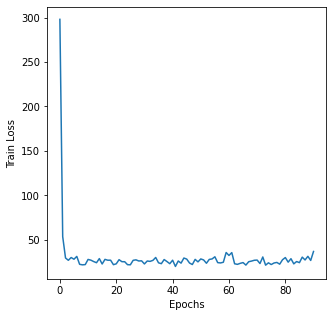

In [23]:
# training hyperparameters
batch_size = 32
num_epochs = 100

# Use best hyperparameter setting, The top row of dataframe is the best hyperparameter
learning_rate = hpo_sorted_df.iloc[0].learning_rate
weight_decay = hpo_sorted_df.iloc[0].weight_decay
dropout_rate = hpo_sorted_df.iloc[0].dropout_rate

model_with_hpo = MLP(n_features, n_hidden, n_output, dropout_rate).to(device)
optimizer = torch.optim.Adam(model_with_hpo.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss() # using Mean Squared Error

# use full training dataset without K-fold
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_logs = []

model_with_hpo.train()
for epoch in range(num_epochs):
    train_loss = 0.
    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        y_pred = model_with_hpo(inputs)

        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.shape[0]

    train_logs.append(train_loss / len(train_dataset))
    
    if epoch % 10 == 0:
        plot_loss(train_logs)
        

In [24]:
train_logs[-1], np.array(train_logs).min()

(21.153400874373936, 19.970730658805017)

## Test model with best hyperparameter

In [25]:
test_logs = []
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss(reduction='sum') # sum loss using Mean Squared Error

model_with_hpo.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = model_with_hpo(inputs)
        test_logs.append(criterion(y_pred, targets).item())

print(f'average test log mse = {sum(test_logs)/ len(test_dataset)}')

average test log mse = 17.681025935154334


# References
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://github.com/scikit-learn/scikit-learn/blob/36958fb24/sklearn/model_selection/_search.py#L1021
- https://towardsdatascience.com/extending-pytorch-with-custom-activation-functions-2d8b065ef2fa
- https://pytorch.org/docs/stable/notes/extending.html

# Test part
***Do not change*** this part and ***Do not add*** cell below this part<br>
- This part is not for students
- Do not use & add below cell

In [26]:
from torch.autograd import gradcheck

input = (torch.rand(32, 13, dtype=torch.float, requires_grad=True)).to(device)

test = gradcheck(model_with_hpo, input, eps=1e-3, atol=1e-2)

/usr/local/lib/python3.7/dist-packages/torch/autograd/gradcheck.py:653: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  f'Input #{idx} requires gradient and '


In [27]:
print(test)

True


In [28]:
print(sum(test_logs)/ len(test_dataset))

17.681025935154334


In [29]:
k_test = 5
k_fold_test = k_fold_data(input, k_test)

check = True

if len(k_fold_test) != k_test:    
    check = False
else:
    for fold in k_fold_test:
        if len(fold[1]) != (input.shape[0] // k_test):
            check = False
            break

print(check)

True
